In [11]:
# Install necessary packages
!pip install xgboost scikit-learn tensorflow keras-tuner statsmodels pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load data
df = pd.read_excel('Australia.xlsx')
df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)

# Clean numeric columns
for col in ['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']:
    df[col] = df[col].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)

# Feature and target setup for Step 1 (predicting Sugar_Prod)
X_prod = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)']]
y_prod = df['Sugar_Prod(tons)']

# Feature and target setup for Step 2 (predicting Exported_sugar, will add predicted Sugar_Prod later)
y_export = df['Exported_sugar(tons)']

# Create polynomial features for Linear Regression and Elastic Net
poly = PolynomialFeatures(degree=2, include_bias=False)
X_prod_poly = poly.fit_transform(X_prod)
poly_feature_names = poly.get_feature_names_out(['Land_used(ha)', 'Sugarcane_Yield(t/ha)'])

# Scale features for SVR, KNN, LSTM, GRU
scaler_prod = MinMaxScaler()
X_prod_scaled = scaler_prod.fit_transform(X_prod)
X_prod_scaled_df = pd.DataFrame(X_prod_scaled, columns=['Land_used(ha)', 'Sugarcane_Yield(t/ha)'])

# Split data (80% train, 20% test, respecting temporal order)
train_size = int(0.8 * len(df))
X_prod_train, X_prod_test = X_prod[:train_size], X_prod[train_size:]
X_prod_train_scaled, X_prod_test_scaled = X_prod_scaled[:train_size], X_prod_scaled[train_size:]
X_prod_train_poly, X_prod_test_poly = X_prod_poly[:train_size], X_prod_poly[train_size:]
y_prod_train, y_prod_test = y_prod[:train_size], y_prod[train_size:]
y_export_train, y_export_test = y_export[:train_size], y_export[train_size:]

In [14]:
# Create sequences for LSTM/GRU (window size = 3)
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 3
X_seq_prod, y_seq_prod = create_sequences(X_prod_scaled, y_prod.values, time_steps)
X_seq_prod_train, y_seq_prod_train = X_seq_prod[:int(0.8 * len(X_seq_prod))], y_seq_prod[:int(0.8 * len(y_seq_prod))]
X_seq_prod_test, y_seq_prod_test = X_seq_prod[int(0.8 * len(X_seq_prod)):], y_seq_prod[int(0.8 * len(y_seq_prod)):]

In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

# Initialize results dictionary for sugar production
results_prod = {}

# Define models and parameters
models = {
    'RandomForest': GridSearchCV(
        RandomForestRegressor(random_state=42),
        {'n_estimators': [50, 100, 200], 'max_depth': [2, 3, 4], 'min_samples_split': [2, 3]},
        cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error'
    ),
    'XGBoost': GridSearchCV(
        XGBRegressor(random_state=42),
        {'n_estimators': [50, 100, 200], 'max_depth': [2, 3], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.8, 1.0]},
        cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error'
    ),
    'GradientBoosting': GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        {'n_estimators': [50, 100, 200], 'max_depth': [2, 3], 'learning_rate': [0.01, 0.05]},
        cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_absolute_error'
    )
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_prod_train, y_prod_train)
    y_pred = model.predict(X_prod_test)
    mae = mean_absolute_error(y_prod_test, y_pred)
    r2 = r2_score(y_prod_test, y_pred)
    mape = mean_absolute_percentage_error(y_prod_test, y_pred) * 100
    results_prod[name] = {
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'predictions': y_pred,
        'best_params': model.best_params_ if hasattr(model, 'best_params_') else None,
        'model': model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    }

# Print results
print("Sugar Production Prediction (Step 1) Performance:")
for name, metrics in results_prod.items():
    print(f"\n--- {name} ---")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R2: {metrics['R2']:.2f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    if metrics['best_params']:
        print(f"Best Params: {metrics['best_params']}")

Sugar Production Prediction (Step 1) Performance:

--- RandomForest ---
MAE: 170599.27
R2: -1.21
MAPE: 3.92%
Best Params: {'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 200}

--- XGBoost ---
MAE: 142048.58
R2: -0.58
MAPE: 3.33%
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

--- GradientBoosting ---
MAE: 194526.59
R2: -1.38
MAPE: 4.52%
Best Params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}


In [19]:
# Select best model for sugar production based on MAE
best_model_prod = min(results_prod.items(), key=lambda x: x[1]['MAE'])[0]
print(f"Best model for Sugar Production: {best_model_prod}")

# Generate predicted Sugar_Prod for train and test sets
if best_model_prod in ['LinearRegression', 'ElasticNet']:
    y_pred_prod_full = results_prod[best_model_prod]['model'].predict(poly.fit_transform(X_prod))
elif best_model_prod in ['SVR', 'KNN']:
    y_pred_prod_full = results_prod[best_model_prod]['model'].predict(scaler_prod.transform(X_prod))
elif best_model_prod in ['LSTM', 'GRU']:
    X_seq_full, _ = create_sequences(X_prod_scaled, y_prod.values, time_steps)
    y_pred_prod_full = np.concatenate([
        np.full(time_steps, y_prod.mean()),  # Fill initial values with mean
        results_prod[best_model_prod]['model'].predict(X_seq_full).flatten()
    ])
elif best_model_prod == 'ARIMA':
    arima_fit_full = ARIMA(y_prod, order=(2, 1, 1)).fit()
    y_pred_prod_full = arima_fit_full.fittedvalues
else:
    y_pred_prod_full = results_prod[best_model_prod]['model'].predict(X_prod)

# Create feature set for export prediction
X_export = X_prod.copy()
X_export['Sugar_Prod_pred'] = y_pred_prod_full
X_export_train, X_export_test = X_export[:train_size], X_export[train_size:]

# Scale features for SVR, KNN, LSTM, GRU
scaler_export = MinMaxScaler()
X_export_scaled = scaler_export.fit_transform(X_export)
X_export_scaled_df = pd.DataFrame(X_export_scaled, columns=['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod_pred'])

# Polynomial features for Linear Regression and Elastic Net
X_export_poly = poly.fit_transform(X_export)
X_export_train_scaled, X_export_test_scaled = X_export_scaled[:train_size], X_export_scaled[train_size:]
X_export_train_poly, X_export_test_poly = X_export_poly[:train_size], X_export_poly[train_size:]

# Sequences for LSTM/GRU
X_seq_export, y_seq_export = create_sequences(X_export_scaled, y_export.values, time_steps)
X_seq_export_train, y_seq_export_train = X_seq_export[:int(0.8 * len(X_seq_export))], y_seq_export[:int(0.8 * len(y_seq_export))]
X_seq_export_test, y_seq_export_test = X_seq_export[int(0.8 * len(X_seq_export)):], y_seq_export[int(0.8 * len(y_seq_export)):]

Best model for Sugar Production: XGBoost


In [21]:
# Initialize results dictionary for export prediction
results_export = {}

# Linear Regression with Polynomial Features
lr_export = LinearRegression()
lr_export.fit(X_export_train_poly, y_export_train)
y_pred_lr_export = lr_export.predict(X_export_test_poly)
results_export['LinearRegression'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_lr_export),
    'R2': r2_score(y_export_test, y_pred_lr_export),
    'predictions': y_pred_lr_export
}

# Random Forest with GridSearchCV
rf_export = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_mean_absolute_error')
rf_export.fit(X_export_train, y_export_train)
y_pred_rf_export = rf_export.predict(X_export_test)
results_export['RandomForest'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_rf_export),
    'R2': r2_score(y_export_test, y_pred_rf_export),
    'predictions': y_pred_rf_export,
    'best_params': rf_export.best_params_
}

# SVR with GridSearchCV
svr_export = GridSearchCV(SVR(), svr_params, cv=3, scoring='neg_mean_absolute_error')
svr_export.fit(X_export_train_scaled, y_export_train)
y_pred_svr_export = svr_export.predict(X_export_test_scaled)
results_export['SVR'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_svr_export),
    'R2': r2_score(y_export_test, y_pred_svr_export),
    'predictions': y_pred_svr_export,
    'best_params': svr_export.best_params_
}

# XGBoost with GridSearchCV
xgb_export = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=3, scoring='neg_mean_absolute_error')
xgb_export.fit(X_export_train, y_export_train)
y_pred_xgb_export = xgb_export.predict(X_export_test)
results_export['XGBoost'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_xgb_export),
    'R2': r2_score(y_export_test, y_pred_xgb_export),
    'predictions': y_pred_xgb_export,
    'best_params': xgb_export.best_params_
}

# Gradient Boosting with GridSearchCV
gb_export = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='neg_mean_absolute_error')
gb_export.fit(X_export_train, y_export_train)
y_pred_gb_export = gb_export.predict(X_export_test)
results_export['GradientBoosting'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_gb_export),
    'R2': r2_score(y_export_test, y_pred_gb_export),
    'predictions': y_pred_gb_export,
    'best_params': gb_export.best_params_
}

# KNN with GridSearchCV
knn_export = GridSearchCV(KNeighborsRegressor(), knn_params, cv=3, scoring='neg_mean_absolute_error')
knn_export.fit(X_export_train_scaled, y_export_train)
y_pred_knn_export = knn_export.predict(X_export_test_scaled)
results_export['KNN'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_knn_export),
    'R2': r2_score(y_export_test, y_pred_knn_export),
    'predictions': y_pred_knn_export,
    'best_params': knn_export.best_params_
}

# Elastic Net with GridSearchCV
en_export = GridSearchCV(ElasticNet(random_state=42), en_params, cv=3, scoring='neg_mean_absolute_error')
en_export.fit(X_export_train_poly, y_export_train)
y_pred_en_export = en_export.predict(X_export_test_poly)
results_export['ElasticNet'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_en_export),
    'R2': r2_score(y_export_test, y_pred_en_export),
    'predictions': y_pred_en_export,
    'best_params': en_export.best_params_
}

# LSTM with Keras Tuner
from tensorflow.keras.layers import Input
import tensorflow as tf
import shutil
import os

# Optionally clear previous tuner directories to avoid optimizer mismatches
def clear_tuner_dirs_export():
    for dir_name in ['lstm_tuning_export', 'gru_tuning_export']:
        if os.path.exists(dir_name):
            shutil.rmtree(dir_name)

# Uncomment the following line if you want to force fresh tuning
# clear_tuner_dirs_export()

def build_lstm_model_export(hp):
    model = Sequential([
        Input(shape=(time_steps, X_export.shape[1])),  # Correct input shape: 3 features
        LSTM(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            return_sequences=hp.Choice('return_sequences', [True, False])
        )
    ])
    if hp.Choice('return_sequences', [True, False]):
        model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=64, step=16)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.Hyperband(
    build_lstm_model_export,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='lstm_tuning_export',
    project_name='sugar_export',
    overwrite=False  # Set to True to force fresh tuning
)
tuner.search(X_seq_export_train, y_seq_export_train, epochs=50, validation_data=(X_seq_export_test, y_seq_export_test), callbacks=[EarlyStopping(patience=10)])
best_lstm_export = tuner.get_best_models(num_models=1)[0]
# Ensure consistent input shape for prediction
X_seq_export_test_tensor = tf.convert_to_tensor(X_seq_export_test, dtype=tf.float32)
y_pred_lstm_export = best_lstm_export.predict(X_seq_export_test_tensor).flatten()
results_export['LSTM'] = {
    'MAE': mean_absolute_error(y_seq_export_test, y_pred_lstm_export),
    'R2': r2_score(y_seq_export_test, y_pred_lstm_export),
    'predictions': y_pred_lstm_export
}

# GRU with Keras Tuner
def build_gru_model_export(hp):
    model = Sequential([
        Input(shape=(time_steps, X_export.shape[1])),  # Correct input shape: 3 features
        GRU(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            return_sequences=hp.Choice('return_sequences', [True, False])
        )
    ])
    if hp.Choice('return_sequences', [True, False]):
        model.add(GRU(units=hp.Int('units_2', min_value=16, max_value=64, step=16)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.Hyperband(
    build_gru_model_export,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='gru_tuning_export',
    project_name='sugar_export',
    overwrite=False  # Set to True to force fresh tuning
)
tuner.search(X_seq_export_train, y_seq_export_train, epochs=50, validation_data=(X_seq_export_test, y_seq_export_test), callbacks=[EarlyStopping(patience=10)])
best_gru_export = tuner.get_best_models(num_models=1)[0]
# Ensure consistent input shape for prediction
X_seq_export_test_tensor = tf.convert_to_tensor(X_seq_export_test, dtype=tf.float32)
y_pred_gru_export = best_gru_export.predict(X_seq_export_test_tensor).flatten()
results_export['GRU'] = {
    'MAE': mean_absolute_error(y_seq_export_test, y_pred_gru_export),
    'R2': r2_score(y_seq_export_test, y_pred_gru_export),
    'predictions': y_pred_gru_export
}

# ARIMA for Exported Sugar
arima_model_export = ARIMA(y_export_train, order=(2, 1, 1))
arima_fit_export = arima_model_export.fit()
y_pred_arima_export = arima_fit_export.forecast(steps=len(y_export_test))
results_export['ARIMA'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_arima_export),
    'R2': r2_score(y_export_test, y_pred_arima_export),
    'predictions': y_pred_arima_export
}

# Stacking Ensemble for Exported Sugar
estimators_export = [
    ('rf', RandomForestRegressor(**rf_export.best_params_, random_state=42)),
    ('xgb', XGBRegressor(**xgb_export.best_params_, random_state=42)),
    ('gb', GradientBoostingRegressor(**gb_export.best_params_, random_state=42)),
    ('svr', SVR(**svr_export.best_params_))
]
stacking_export = StackingRegressor(estimators=estimators_export, final_estimator=LinearRegression())
stacking_export.fit(X_export_train, y_export_train)
y_pred_stack_export = stacking_export.predict(X_export_test)
results_export['Stacking'] = {
    'MAE': mean_absolute_error(y_export_test, y_pred_stack_export),
    'R2': r2_score(y_export_test, y_pred_stack_export),
    'predictions': y_pred_stack_export
}

Trial 30 Complete [00h 00m 04s]
val_loss: 11016716943360.0

Best val_loss So Far: 11016716943360.0
Total elapsed time: 00h 01m 51s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Sugar Production Prediction (Step 1) Performance:

--- LinearRegression ---
MAE: 249319.67
R2: -3.08

--- RandomForest ---
MAE: 148565.83
R2: -0.77
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

--- SVR ---
MAE: 396480.58
R2: -9.81
Best Params: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}

--- XGBoost ---
MAE: 107722.96
R2: -0.18
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

--- GradientBoosting ---
MAE: 153785.14
R2: -0.79
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}

--- KNN ---
MAE: 284150.00
R2: -5.27
Best Params: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

--- ElasticNet ---
MAE: 223434.69
R2: -2.56
Best Params: {'alpha': 0.1, 'l1_ratio': 0.8}

--- LSTM ---
MAE: 4309688.76
R2: -875.52

--- GRU ---
MAE: 4309688.70
R2: -875.52

--- ARIMA ---
MAE: 439129.47
R2: -12.05

--- Stacking ---
MAE: 310546.32
R2: -8.62

Exported Sugar Prediction (Step 2) Performance:

--- Linear

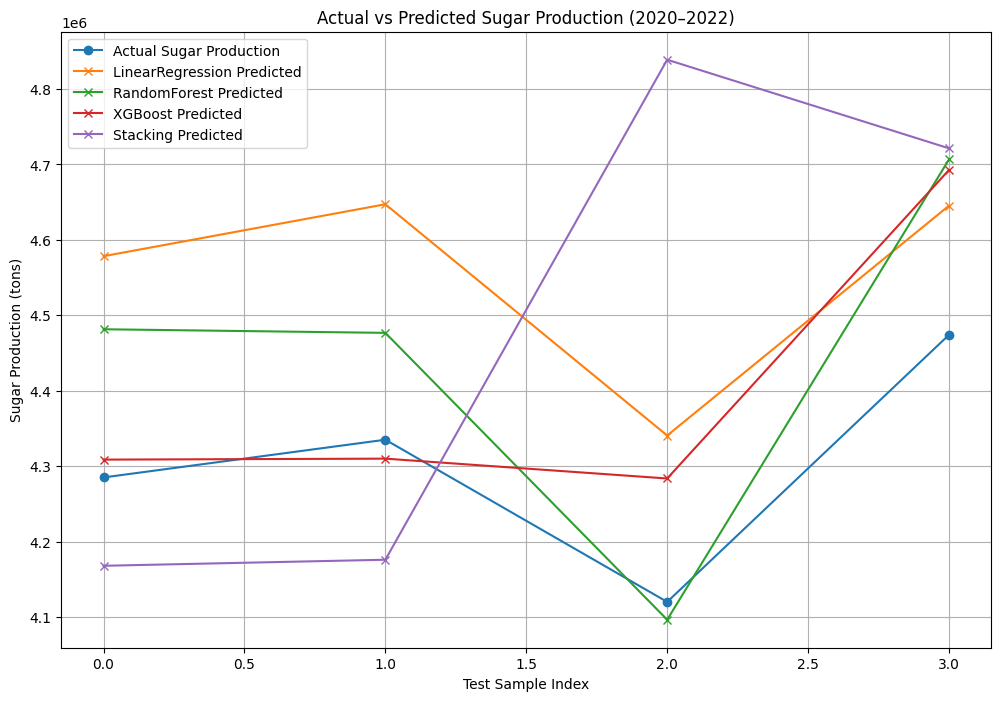

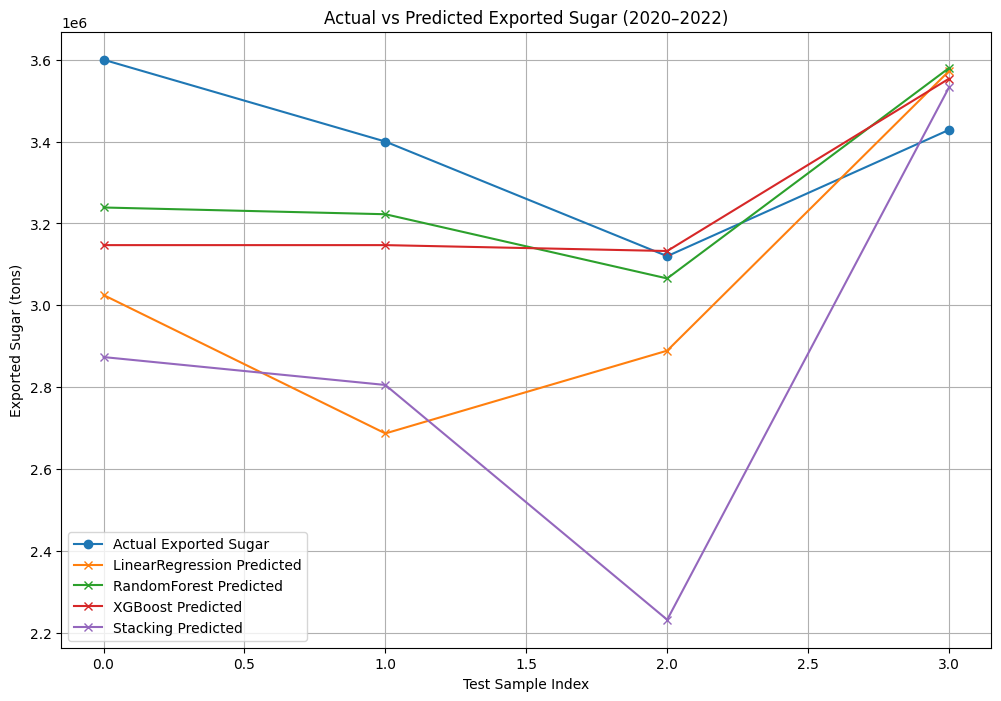

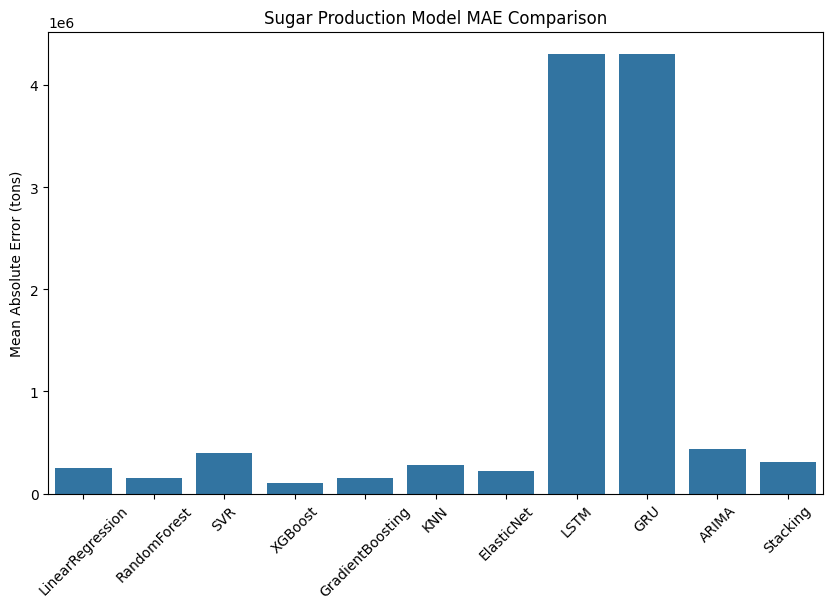

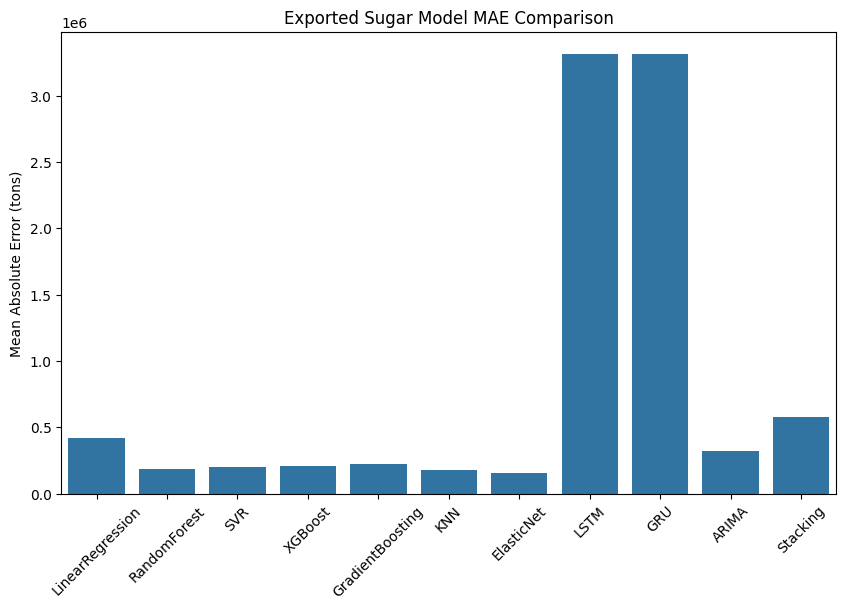

In [22]:
# Print results for Sugar Production
print("Sugar Production Prediction (Step 1) Performance:")
for name, metrics in results_prod.items():
    print(f"\n--- {name} ---")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R2: {metrics['R2']:.2f}")
    if 'best_params' in metrics:
        print(f"Best Params: {metrics['best_params']}")

# Print results for Exported Sugar
print("\nExported Sugar Prediction (Step 2) Performance:")
for name, metrics in results_export.items():
    print(f"\n--- {name} ---")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R2: {metrics['R2']:.2f}")
    if 'best_params' in metrics:
        print(f"Best Params: {metrics['best_params']}")

# Plot Actual vs Predicted for Sugar Production
plt.figure(figsize=(12, 8))
plt.plot(y_prod_test.values, label='Actual Sugar Production', marker='o')
for name in ['LinearRegression', 'RandomForest', 'XGBoost', 'Stacking']:
    plt.plot(results_prod[name]['predictions'], label=f'{name} Predicted', marker='x')
plt.title('Actual vs Predicted Sugar Production (2020–2022)')
plt.xlabel('Test Sample Index')
plt.ylabel('Sugar Production (tons)')
plt.legend()
plt.grid(True)
plt.savefig('sugar_production_actual_vs_predicted.png')
plt.show()

# Plot Actual vs Predicted for Exported Sugar
plt.figure(figsize=(12, 8))
plt.plot(y_export_test.values, label='Actual Exported Sugar', marker='o')
for name in ['LinearRegression', 'RandomForest', 'XGBoost', 'Stacking']:
    plt.plot(results_export[name]['predictions'], label=f'{name} Predicted', marker='x')
plt.title('Actual vs Predicted Exported Sugar (2020–2022)')
plt.xlabel('Test Sample Index')
plt.ylabel('Exported Sugar (tons)')
plt.legend()
plt.grid(True)
plt.savefig('exported_sugar_actual_vs_predicted.png')
plt.show()

# Bar plot for MAE comparison (Sugar Production)
maes_prod = [metrics['MAE'] for metrics in results_prod.values()]
models_prod = list(results_prod.keys())
plt.figure(figsize=(10, 6))
sns.barplot(x=models_prod, y=maes_prod)
plt.title('Sugar Production Model MAE Comparison')
plt.ylabel('Mean Absolute Error (tons)')
plt.xticks(rotation=45)
plt.savefig('sugar_production_mae_comparison.png')
plt.show()

# Bar plot for MAE comparison (Exported Sugar)
maes_export = [metrics['MAE'] for metrics in results_export.values()]
models_export = list(results_export.keys())
plt.figure(figsize=(10, 6))
sns.barplot(x=models_export, y=maes_export)
plt.title('Exported Sugar Model MAE Comparison')
plt.ylabel('Mean Absolute Error (tons)')
plt.xticks(rotation=45)
plt.savefig('exported_sugar_mae_comparison.png')
plt.show()

In [9]:
# Stacking Ensemble
estimators = [
    ('rf', RandomForestRegressor(**rf.best_params_, random_state=42)),
    ('xgb', XGBRegressor(**xgb.best_params_, random_state=42)),
    ('gb', GradientBoostingRegressor(**gb.best_params_, random_state=42)),
    ('svr', SVR(**svr.best_params_))
]
stacking = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_test)
results['Stacking'] = {
    'MAE': mean_absolute_error(y_test, y_pred_stack),
    'R2': r2_score(y_test, y_pred_stack),
    'predictions': y_pred_stack
}

Model Performance:

--- LinearRegression ---
MAE: 249319.67
R2: -3.08

--- RandomForest ---
MAE: 148565.83
R2: -0.77
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

--- SVR ---
MAE: 396480.58
R2: -9.81
Best Params: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}

--- XGBoost ---
MAE: 107722.96
R2: -0.18
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

--- GradientBoosting ---
MAE: 153785.14
R2: -0.79
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}

--- KNN ---
MAE: 284150.00
R2: -5.27
Best Params: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

--- ElasticNet ---
MAE: 223434.69
R2: -2.56
Best Params: {'alpha': 0.1, 'l1_ratio': 0.8}

--- LSTM ---
MAE: 4309688.74
R2: -875.52

--- GRU ---
MAE: 4309688.56
R2: -875.52

--- ARIMA ---
MAE: 439129.47
R2: -12.05

--- Stacking ---
MAE: 310546.32
R2: -8.62


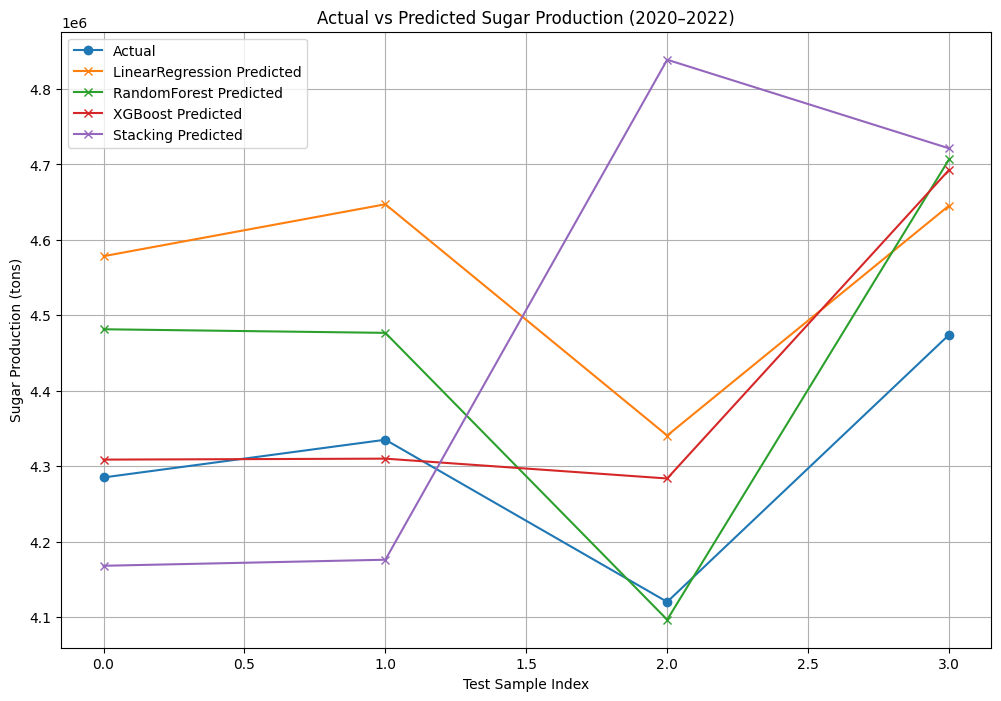

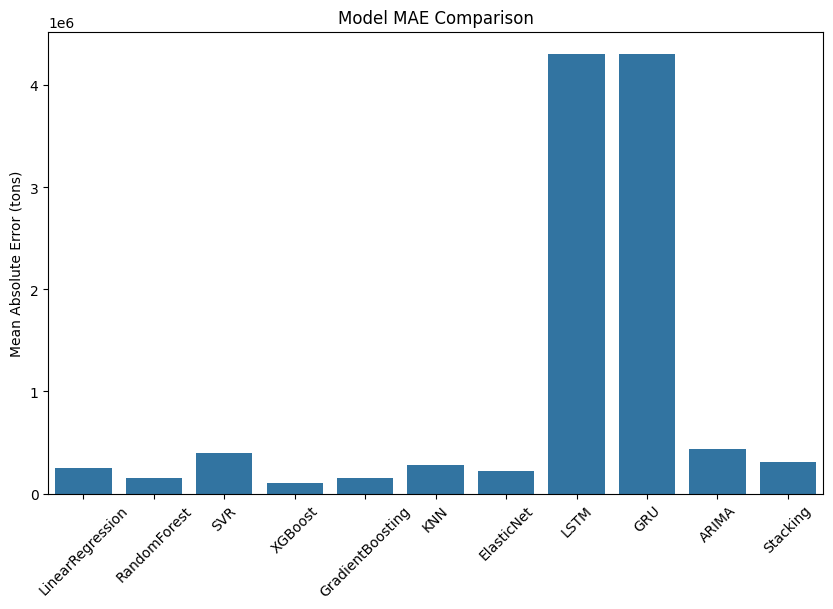

In [10]:
# Print results
print("Model Performance:")
for name, metrics in results.items():
    print(f"\n--- {name} ---")
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"R2: {metrics['R2']:.2f}")
    if 'best_params' in metrics:
        print(f"Best Params: {metrics['best_params']}")

# Plot Actual vs Predicted for top models
plt.figure(figsize=(12, 8))
plt.plot(y_test.values, label='Actual', marker='o')
for name in ['LinearRegression', 'RandomForest', 'XGBoost', 'Stacking']:
    plt.plot(results[name]['predictions'], label=f'{name} Predicted', marker='x')
plt.title('Actual vs Predicted Sugar Production (2020–2022)')
plt.xlabel('Test Sample Index')
plt.ylabel('Sugar Production (tons)')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()

# Bar plot for MAE comparison
maes = [metrics['MAE'] for metrics in results.values()]
models = list(results.keys())
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=maes)
plt.title('Model MAE Comparison')
plt.ylabel('Mean Absolute Error (tons)')
plt.xticks(rotation=45)
plt.savefig('mae_comparison.png')
plt.show()